# Set up

In [1]:
import numpy as np
import sys
import os
import glob
import importlib
import math as m
import pickle as pickle
import seaborn as sns
import statistics
import pandas as pd
fmts = ['svg','pdf']
from scipy.stats import norm, wilcoxon, ttest_rel, friedmanchisquare, shapiro,f_oneway,friedmanchisquare,rankdata
import statsmodels.stats.multitest as smm
from scipy import signal, fft
from scipy.optimize import curve_fit, minimize
import scipy.interpolate as interp
import matplotlib # produce matlab-style plots
from matplotlib import animation as ani # animation
import matplotlib.pyplot as plt # Matlab-style plotting
from matplotlib import rcParams
from matplotlib.lines import Line2D
from itertools import combinations
matplotlib.rc('font',**{'size':20}) # increase font size on plots
matplotlib.rc('text',usetex=False) # use LaTeX to render symbols
matplotlib.rc('animation',html='html5') # render animation
prop_cycle = plt.rcParams['axes.prop_cycle']
python_colors = prop_cycle.by_key()['color'] # python default color cycle

# auto reload modules
%load_ext autoreload
%autoreload 2
sys.path.append('C:\\Users\\amber\\Documents\\GitHub\\sensorimotor_fusion\\analysis\\Multimodal paper') # change this for your computer
# DATA_PATH = 'C:\\Users\\amber\\Documents\\GitHub\\sensorimotor_fusion' #change this for your computer

In [21]:
rcParams.update(matplotlib.rcParamsDefault)
# font = {#'family': 'serif', 'serif': ['Computer Modern'],
#         'weight' : 'ultralight',
#         'size'   : 14}
# matplotlib.rc('font', **font)
rcParams['axes.titlesize'] = 14
rcParams['font.size'] = 14
rcParams['font.weight'] = 'ultralight'
# rcParams['font.family'] = 'sans-serif'
rcParams['mathtext.fontset'] = 'cm'
# rcParams['text.usetex'] = True
rcParams['font.family'] = 'serif'

In [3]:
from globalVars import *
from collect_data import findFilename, getrawdata, get_data, analyze
from analysis import *

In [4]:
print('data length = ',N)
print('primes = ',primes)
print('base freq = ',base_freq)
print('IX = ',IX)
print('Even_IX = ',Even_IX)
print('Odd_IX = ',Odd_IX)
print('freqs = ',freqs)
print('omegas = ',omegas)
print('T = ',T) # total time 40 seconds
print('t = ',t) # timestamps
print('fs = ',fs)
print('sample_period (dt)= ',dt)
print('xf = ',xf) # frequency domain x-axis, shape (N//2,)
print('Machine = ',M) # soM at stimulated freqs
print('scaleInput = ',scaleInput)
print('scaleOutputScreen = ',scaleOutputScreen)

data length =  2400
primes =  [ 2  3  5  7 11 13 17 19]
base freq =  0.05
IX =  [ 4  6 10 14 22 26 34 38]
Even_IX =  [ 6 14 26 38]
Odd_IX =  [ 4 10 22 34]
freqs =  [0.1  0.15 0.25 0.35 0.55 0.65 0.85 0.95]
omegas =  [0.62831853 0.9424778  1.57079633 2.19911486 3.45575192 4.08407045
 5.34070751 5.96902604]
T =  40
t =  [0.00000000e+00 1.66736140e-02 3.33472280e-02 ... 3.99666528e+01
 3.99833264e+01 4.00000000e+01]
fs =  60
sample_period (dt)=  0.016666666666666666
xf =  [0.0000e+00 2.5000e-02 5.0000e-02 ... 2.9925e+01 2.9950e+01 2.9975e+01]
Machine =  [-0.7169568 -1.14107219j -0.52958685-0.5619091j  -0.28840044-0.18360142j
 -0.17134712-0.0779164j  -0.07726649-0.02235881j -0.05656227-0.01384948j
 -0.03387172-0.00634218j -0.02730057-0.00457371j]
scaleInput =  0.04616974606700115
scaleOutputScreen =  0.25


# Load data

In [5]:
# with open('multimodal_data.pkl', 'wb') as file:
#     pickle.dump(ALLdata, file)

# Load the array from the file
with open('multimodal_data.pkl', 'rb') as file:
    Rs,Ds,Us,U0s,U1s,Ys,rs,ds,us,u0s,u1s,ys,errors,Tur,Tu0r,Tu1r,Tud,Tu0d,Tu1d,Tyr,Tyd,F,B,F0,F1,B0,B1 = pickle.load(file)

In [6]:
print(Rs.shape) # subject x condition x trial x all freqs
print(rs.shape) # subject x condition x trial x timestamps
print(errors.shape) # subject x condition x trial

subject_num = Rs.shape[0]
condition_num = Rs.shape[1]
trial_num = Rs.shape[2]
print('subject_num = ',subject_num)
print('condition_num (alphas) = ',condition_num)
print('trial_num = ',trial_num)
alphas = np.array([0,0.25,0.5,0.75,1])
# conditions = ['0','0.25','0.5','0.75','1']
conditions = ['0','25','50','75','100']
# conditions = ['0:1','1:3','1:1','3:1','1:0']
# conditions = ['0:1','1:3','1:1','3:1','1:0']

(15, 5, 14, 2400)
(15, 5, 14, 2400)
(15, 5, 14)
subject_num =  15
condition_num (alphas) =  5
trial_num =  14


# Simuli

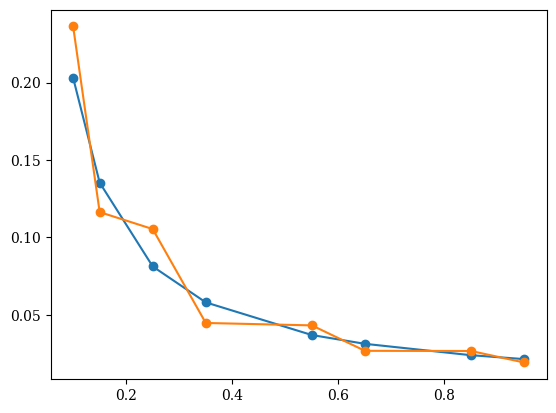

In [18]:
Stimuli = np.zeros(IX.shape,dtype = complex)
Stimuli[::2] = Rs[0,0,-1,IX][::2] 
Stimuli[1::2] = Rs[0,0,-2,IX][1::2] 
plt.plot(freqs,np.abs(Stimuli),'-o')

Stimuli = np.zeros(IX.shape,dtype = complex)
Stimuli[::2] = Ds[0,0,-1,IX][1::2] 
Stimuli[1::2] = Ds[0,0,-2,IX][::2] 
plt.plot(freqs,np.abs(M*Stimuli),'-o')

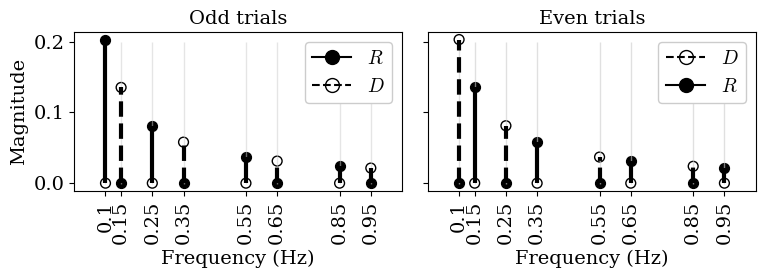

In [23]:
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
sub = 0
cond = 0

fig,axs = plt.subplots(1, 2,sharex = True,sharey = True,figsize=(8, 3)) 
ax = axs[0]
trial = 1
ax.vlines(freqs,ymin=-0.001, ymax=0.2,linewidth=1, color='0.8',alpha = 0.5)
R = np.abs( Rs[sub,cond,trial,IX] )
D = np.abs( M*Ds[sub,cond,trial,IX] )
ax.scatter(freqs,R, color='black',label=r'$R$_{odd}',s=50)
ax.scatter(freqs,D, color='black',label=r'$D_{even}$',facecolors='none',s=50)
ax.vlines(freqs,np.zeros((len(IX),)),R,color='black',linewidth = 3)
ax.vlines(freqs,np.zeros((len(IX),)),D,linestyles='--',color='black',linewidth = 3)
ax.set_xlim((0,21*base_freq))
# ax.set_ylim((-0.2,6))
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Magnitude')
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,rotation=90) 
legend_elements = [Line2D([0], [0], marker='o', color='black' ,label=r'$R$',markersize=10),
                   Line2D([0], [0], ls = '--',marker='o',color='black', label=r'$D$',markerfacecolor='none',markersize=10)]
ax.legend(handles=legend_elements, loc='upper right', ncol=1, frameon=True, prop={'size': 14},facecolor = 'white',framealpha = 1)
ax.set_title('Odd trials')

ax = axs[1]
trial = 0
ax.vlines(freqs,ymin=-0.001, ymax=0.2,linewidth=1, color='0.8',alpha = 0.6)
R = np.abs( Rs[sub,cond,trial,IX] )
D = np.abs( M*Ds[sub,cond,trial,IX] )
ax.scatter(freqs,R, color='black',label=r'$R$_{odd}',s=50)
ax.scatter(freqs,D, color='black',label=r'$D_{even}$',facecolors='none',s=50)
ax.vlines(freqs,np.zeros((len(IX),)),R,color='black',linewidth = 3)
ax.vlines(freqs,np.zeros((len(IX),)),D,linestyles='--',color='black',linewidth = 3)
ax.set_xlim((0,21*base_freq))
# ax.set_ylim((-0.2,6))
ax.set_xlabel('Frequency (Hz)')
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,rotation=90) 
legend_elements = [Line2D([0], [0], ls = '--', marker='o',color='black', label=r'$D$',markerfacecolor='none',markersize=10),
                   Line2D([0], [0], marker='o', color='black' ,label=r'$R$',markersize=10)]
ax.legend(handles=legend_elements, loc='upper right', ncol=1, frameon=True, prop={'size': 14},facecolor = 'white',framealpha = 1)
ax.set_title('Even trials')
plt.tight_layout()
fig.savefig('stimuli.svg')
plt.show()

# Hypothesis 1

## Stats tests

Hypothesis: any of the conditions (25, 50, or 75) is better than condition 0 or condition 100. So six pairwise comparisons:
25 vs. 0
50 vs. 0
75 vs. 0
25 vs. 100
50 vs. 100
75 vs. 100

In [24]:
def stats_test(datas):
    # Compute residuals (observed - condition mean)
    residuals_0 = datas[0] - np.mean(datas[0])
    residuals_25 = datas[1] - np.mean(datas[1])
    residuals_50 = datas[2] - np.mean(datas[2])
    residuals_75 = datas[3] - np.mean(datas[3])
    residuals_100 = datas[4] - np.mean(datas[4])

    # Combine residuals from all conditions
    all_residuals = np.concatenate([residuals_0, residuals_25, residuals_50, residuals_75, residuals_100])

    # Perform Shapiro-Wilk test on residuals
    stat, p = shapiro(all_residuals)
    print(f'Shapiro-Wilk Test Statistic={stat:.4f}, p-value={p:.4f}')
    if p > 0.05:
        print("Residuals appear to be normally distributed (fail to reject H0).")
        stat, p = f_oneway(datas[0],datas[1],datas[2],datas[3],datas[4]) #see if p < 0.05, there is a significant difference
        print(f'One-way ANOVA Statistic={stat:.4f}, p-value={p:.4f}')
    else:
        print("Residuals are NOT normally distributed (reject H0).") 
         # Perform Friedman test
        stat, p = friedmanchisquare(datas[0],datas[1],datas[2],datas[3],datas[4])
        print(f'Friedman Test Statistic={stat:.4f}, p-value={p:.4f}') # If p < 0.05, there is a significant difference
        if p <= 0.05:
            print('Friedman Test: significant difference')
            # post hoc test with Wilcoxon signed-rank tests with Bonferroni correction
            comparisons = [
                ("25 vs. 0", datas[1], datas[0]),
                ("50 vs. 0", datas[2], datas[0]),
                ("75 vs. 0", datas[3], datas[0]),
                ("25 vs. 100", datas[1], datas[4]),
                ("50 vs. 100", datas[2], datas[4]),
                ("75 vs. 100", datas[3], datas[4])
            ]
            p_values = []
            for name, cond1, cond2 in comparisons:
                stat, p = wilcoxon(cond1, cond2)
                p_values.append(p)
            # # Apply Bonferroni correction (dividing α by 6)
            # corrected_p_values = smm.multipletests(p_values, method='bonferroni')[1]
            # for (name, _, _), p_raw, p_corr in zip(comparisons, p_values, corrected_p_values):
            #     print(f'{name}: Raw p-value = {p_raw:.4f}, Bonferroni-corrected p-value = {p_corr:.4f}')

            # Apply Holm-Sidak Correction
            corrected_p_values = smm.multipletests(p_values, method='holm-sidak')[1]
            for (name, _, _), p_raw, p_corr in zip(comparisons, p_values, corrected_p_values):
                print(f'{name}: Raw p-value = {p_raw:.4f}, Holm-Sidak corrected p-value = {p_corr:.4f}')

        else:
            print('Friedman Test: no significant difference')

In [25]:
# if comparing every pairs (10 comarisons)

            # # post hoc test with Wilcoxon signed-rank tests with Bonferroni correction
            # pairs = list(combinations(range(len(datas)), 2))
            # p_values = []
            # pair_labels = []
            # for i, j in pairs:
            #     stat, p = wilcoxon(datas[i], datas[j])
            #     p_values.append(p)
            #     pair_labels.append(f"{conditions[i]} vs {conditions[j]}")

            # # Print uncorrected p-values
            # # for pair, p in zip(pair_labels, p_values):
            #     # print(f'Wilcoxon test {pair}: p-value={p:.4f}')

            # # Apply Bonferroni correction, divides the significance level (0.05) by the number of comparisons (10)
            # corrected_p_values = smm.multipletests(p_values, method='bonferroni')[1]

            # # Print Bonferroni-corrected p-values
            # print("\nBonferroni-Corrected P-values:")
            # for pair, p_corr in zip(pair_labels, corrected_p_values):
            #     print(f'{pair}: p-value={p_corr:.4f}')

## Performances

In [26]:
ALL = []
last_trials = trial_num - 5 # removing the first 5 trials 

In [27]:
# (1) time domain r-y
datas = []
for cond in range(condition_num):
    datas.append( np.mean((rs[:,cond,-last_trials:] - ys[:,cond,-last_trials:])**2,axis = (1,2)) )#mean across all trials and timestamps
stats_test(datas)
ALL.append(datas)

Shapiro-Wilk Test Statistic=0.6412, p-value=0.0000
Residuals are NOT normally distributed (reject H0).
Friedman Test Statistic=14.5067, p-value=0.0058
Friedman Test: significant difference
25 vs. 0: Raw p-value = 0.0256, Holm-Sidak corrected p-value = 0.1215
50 vs. 0: Raw p-value = 0.0012, Holm-Sidak corrected p-value = 0.0069
75 vs. 0: Raw p-value = 0.1070, Holm-Sidak corrected p-value = 0.3641
25 vs. 100: Raw p-value = 0.8904, Holm-Sidak corrected p-value = 0.9616
50 vs. 100: Raw p-value = 0.2769, Holm-Sidak corrected p-value = 0.6218
75 vs. 100: Raw p-value = 0.8040, Holm-Sidak corrected p-value = 0.9616


In [28]:
# (2) freq domain, stimulated freqs
datas = []
indices = IX[:3] # non-stimulus freqs below 0.25hz 
TF = Rs[:,:,-last_trials:,indices] - Ys[:,:,-last_trials:,indices] # R-Y below 0.25 Hz, all freqs
for cond in range(condition_num):
    datas.append( np.mean((np.abs(TF[:,cond,:,:]))**2, axis = (1,2)) )#mean across all trials and freqs
stats_test(datas)
ALL.append(datas)

Shapiro-Wilk Test Statistic=0.7904, p-value=0.0000
Residuals are NOT normally distributed (reject H0).
Friedman Test Statistic=15.8400, p-value=0.0032
Friedman Test: significant difference
25 vs. 0: Raw p-value = 0.2293, Holm-Sidak corrected p-value = 0.6472
50 vs. 0: Raw p-value = 0.0054, Holm-Sidak corrected p-value = 0.0318
75 vs. 0: Raw p-value = 0.1514, Holm-Sidak corrected p-value = 0.5600
25 vs. 100: Raw p-value = 0.6387, Holm-Sidak corrected p-value = 0.9528
50 vs. 100: Raw p-value = 0.8904, Holm-Sidak corrected p-value = 0.9880
75 vs. 100: Raw p-value = 0.8904, Holm-Sidak corrected p-value = 0.9880


In [29]:
# (3) freq domain, non-stimulated freqs
datas = []
indices = np.setdiff1d(np.arange(0,11), IX) # non-stimulus freqs below 0.25hz 
TF = Rs[:,:,-last_trials:,indices] - Ys[:,:,-last_trials:,indices] # R-Y below 0.25 Hz, all freqs
for cond in range(condition_num):
    datas.append( np.mean((np.abs(TF[:,cond,:,:]))**2, axis = (1,2)) )#mean across all trials and freqs
stats_test(datas)
ALL.append(datas)

Shapiro-Wilk Test Statistic=0.5887, p-value=0.0000
Residuals are NOT normally distributed (reject H0).
Friedman Test Statistic=15.9467, p-value=0.0031
Friedman Test: significant difference
25 vs. 0: Raw p-value = 0.1205, Holm-Sidak corrected p-value = 0.4018
50 vs. 0: Raw p-value = 0.0043, Holm-Sidak corrected p-value = 0.0254
75 vs. 0: Raw p-value = 0.5245, Holm-Sidak corrected p-value = 0.8925
25 vs. 100: Raw p-value = 0.6788, Holm-Sidak corrected p-value = 0.8925
50 vs. 100: Raw p-value = 0.0054, Holm-Sidak corrected p-value = 0.0266
75 vs. 100: Raw p-value = 0.5614, Holm-Sidak corrected p-value = 0.8925


In [30]:
# (4) F-M^-1
datas = []
TF = F[:,:,-last_trials//2:,:3] - (M**(-1))[:3] # at stim below 0.25 Hz
for cond in range(condition_num):
    datas.append( np.mean((np.abs(TF[:,cond,:,:]))**2, axis = (1,2)) )#mean across all trials and freqs
stats_test(datas)
ALL.append(datas)

Shapiro-Wilk Test Statistic=0.6559, p-value=0.0000
Residuals are NOT normally distributed (reject H0).
Friedman Test Statistic=7.4667, p-value=0.1132
Friedman Test: no significant difference


In [31]:
# (5) phase margin of open loop TF L = BM
PM = np.zeros((subject_num,condition_num))
GM = np.zeros((subject_num,condition_num))
for sub in range(subject_num):
    for cond in range(condition_num):
        L = B[sub,cond,-last_trials:,2] * M[2] #all trial @ crossover freq (at 0.25Hz)
        PM[sub,cond] = np.mean(np.pi + np.angle(L)) #mean across trials
        GM[sub,cond] = np.mean(np.abs(L)) #mean across trials #in dB?
print(PM.shape)
stats_test([PM[:,0],PM[:,1],PM[:,2],PM[:,3],PM[:,4]])
ALL.append(datas)
print('\n')

# (6) gain margin
stats_test([GM[:,0],GM[:,1],GM[:,2],GM[:,3],GM[:,4]])
ALL.append(datas)

(15, 5)
Shapiro-Wilk Test Statistic=0.8108, p-value=0.0000
Residuals are NOT normally distributed (reject H0).
Friedman Test Statistic=32.9067, p-value=0.0000
Friedman Test: significant difference
25 vs. 0: Raw p-value = 0.8469, Holm-Sidak corrected p-value = 0.9864
50 vs. 0: Raw p-value = 0.7615, Holm-Sidak corrected p-value = 0.9864
75 vs. 0: Raw p-value = 0.0256, Holm-Sidak corrected p-value = 0.0984
25 vs. 100: Raw p-value = 0.0015, Holm-Sidak corrected p-value = 0.0076
50 vs. 100: Raw p-value = 0.0001, Holm-Sidak corrected p-value = 0.0004
75 vs. 100: Raw p-value = 0.8040, Holm-Sidak corrected p-value = 0.9864


Shapiro-Wilk Test Statistic=0.9696, p-value=0.0682
Residuals appear to be normally distributed (fail to reject H0).
One-way ANOVA Statistic=0.4061, p-value=0.8037


## plot

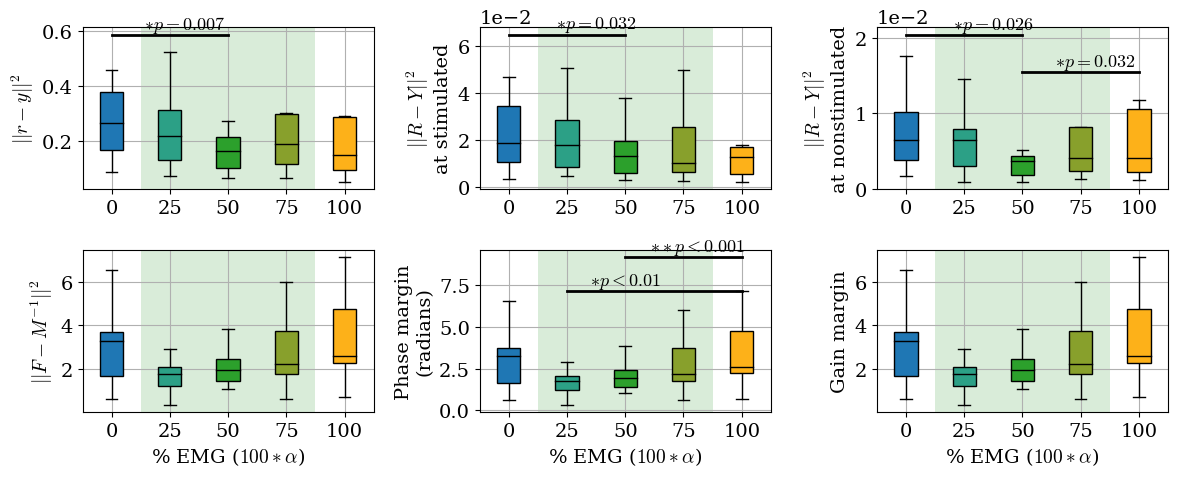

In [43]:
labels = conditions #slider : EMG
boxcolors = [colors['BLUE'],'#2ca086',colors['GREEN'],'#88a02c',colors['GOLD']]

def boxplot(ax,datas):
    bplot = ax.boxplot(datas, widths = 0.4,patch_artist=True,labels=labels, showfliers=False)
    for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('black')
    face0 = ax.axvspan(1.5,4.5, facecolor='green', alpha=0.15)
    ax.grid('on',zorder=-1)

fig,axs = plt.subplots(2,3,figsize=(12,5))
ax = axs[0,0]
datas = ALL[0]
boxplot(ax,datas)
ax.set_ylabel(r'$||r-y||^2$',fontsize = 14)
larger_value = np.max([np.percentile(datas[0], 90),np.percentile(datas[2], 90)]) # significant difference
ax.plot([1, 3], [larger_value-0.2,larger_value-0.2], color='black', lw=2)
ax.text(2.25, larger_value-0.2, r'$*p=0.007$', ha='center', va='bottom', fontsize=13, color='black')

ax = axs[0,1]
datas = ALL[1]
boxplot(ax,datas)
ax.set_ylabel(r'$||R-Y||^2$''\n''at stimulated',fontsize = 14)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
larger_value = np.max([np.percentile(datas[0], 90),np.percentile(datas[2], 90)]) # significant difference
ax.plot([1, 3], [larger_value-0.0005,larger_value-0.0005], color='black', lw=2)
ax.text(2.5, larger_value-0.0004, r'$*p=0.032$', ha='center', va='bottom', fontsize=13, color='black')

ax = axs[0,2]
datas = ALL[2]
boxplot(ax,datas)
ax.set_ylabel(r'$||R-Y||^2$''\n''at nonstimulated',fontsize = 14)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
larger_value = np.max([np.percentile(datas[0], 90),np.percentile(datas[2], 90)]) # significant difference
ax.plot([1, 3], [larger_value-0.005,larger_value-0.005], color='black', lw=2)
ax.text(2.5, larger_value-0.005, r'$*p=0.026$', ha='center', va='bottom', fontsize=13, color='black')

# larger_value = np.max([np.percentile(datas[2], 90),np.percentile(datas[4], 90)]) # significant difference
ax.plot([3, 5], [larger_value-0.01,larger_value-0.01], color='black', lw=2)
ax.text(4.25, larger_value-0.01, r'$*p=0.032$', ha='center', va='bottom', fontsize=13, color='black')

ax = axs[1,0]
datas = ALL[3]
boxplot(ax,datas)
ax.set_ylabel(r'$||F-M^{-1}||^2$',fontsize = 14)
ax.set_xlabel(r'% EMG ($100*\alpha$)',fontsize = 14) #add x axis labels

ax = axs[1,1]
datas = ALL[4]
boxplot(ax,datas)
ax.set_ylabel('Phase margin''\n''(radians)',fontsize = 14)
ax.set_xlabel(r'% EMG ($100*\alpha$)',fontsize = 14) #add x axis labels
larger_value = np.max([np.percentile(datas[1], 90),np.percentile(datas[4], 90)]) # significant difference
ax.plot([2, 5], [larger_value-2,larger_value-2], color='black', lw=2)
ax.text(3, larger_value-2, r'$*p<0.01$', ha='center', va='bottom', fontsize=13, color='black')

larger_value = np.max([np.percentile(datas[2], 90),np.percentile(datas[4], 90)]) # significant difference
ax.plot([3, 5], [larger_value,larger_value], color='black', lw=2)
ax.text(4.25, larger_value, r'$**p<0.001$', ha='center', va='bottom', fontsize=13, color='black')

ax = axs[1,2]
datas = ALL[5]
boxplot(ax,datas)
ax.set_ylabel('Gain margin',fontsize = 14)
ax.set_xlabel(r'% EMG ($100*\alpha$)',fontsize = 14) #add x axis labels

plt.tight_layout()
fig.savefig('performances.svg')
plt.show()

# Hypothesis 2

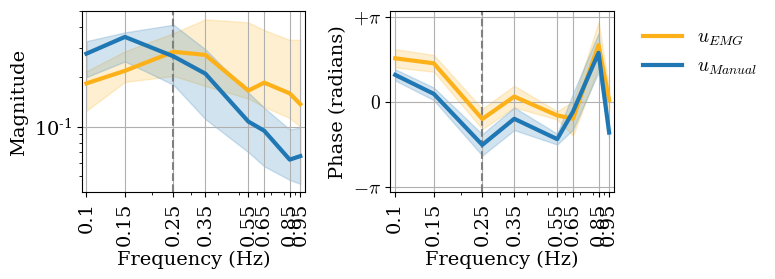

In [53]:
# population level for Even trials
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
ylimphase = (-np.pi-0.2,np.pi+ 0.2)
yticksphase = [-np.pi,0.,np.pi]
yticklabelsphase = [r'$-\pi$',r'$0$',r'$+\pi$']

cond = 2
last_trials = 10
fig,axs = plt.subplots(1,2,sharex=True,figsize=(8,3))

# magnitude
ax = axs[0]
ax.axvline(x=0.25, color='grey', linestyle='--')
U0_mean = np.mean(np.abs(U0s[:,cond,-last_trials:,:][:,:,IX]),axis = 1) #mean across all trials
q25,q50,q75 = np.quantile(U0_mean,[0.25,0.5,0.75],axis = 0) # across subjects
ax.plot(freqs,q50,'-',label = 'EMG input',color = colors['GOLD'],linewidth = 3)
ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['GOLD'])

U1_mean = np.mean(np.abs(U1s[:,cond,-last_trials:,:][:,:,IX]),axis = 1) #mean across all trials
q25,q50,q75 = np.quantile(U1_mean,[0.25,0.5,0.75],axis = 0) # across subjects
ax.plot(freqs,q50,'-',label = 'Manual input',color = colors['BLUE'],linewidth = 3)
ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['BLUE'])

ax.set_xscale("log")
ax.set_xlim(xlim)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,rotation=90) 
ax.grid('on',zorder=-1)
# ax.set_ylim(0.1,80)
ax.set_yscale("log")
ax.set_ylabel('Magnitude')
ax.set_xlabel('Frequency (Hz)')

# phase
ax = axs[1]
ax.axvline(x=0.25, color='grey', linestyle='--')
angles = np.angle(np.mean(np.exp(1j*(np.angle(U0s[:,cond,-last_trials:,:][:,:,IX]))),axis = 1))
z = np.mean(np.exp(1j*(angles-np.pi/2)), axis=0)
mean = np.angle(z)+np.pi/2
disp = 1 - np.abs(z)
ax.plot(freqs,mean,'-',label = r'$u_{EMG}$',color = colors['GOLD'],linewidth = 3)
ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['GOLD'])

angles = np.angle(np.mean(np.exp(1j*(np.angle(U1s[:,cond,-last_trials:,:][:,:,IX]))),axis = 1))
z = np.mean(np.exp(1j*(angles)), axis=0)
mean = np.angle(z)
disp = 1 - np.abs(z)
ax.plot(freqs,mean,'-',label = r'$u_{Manual}$',color = colors['BLUE'],linewidth = 3)
ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['BLUE'])

ax.set_ylabel('Phase (radians)') 
ax.grid('on',zorder=-1)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,rotation=90) 
ax.set_ylim(ylimphase)
ax.set_yticks(yticksphase)
ax.set_yticklabels(yticklabelsphase)
ax.set_xlabel('Frequency (Hz)')
# ax.legend(loc = 'lower left',frameon=False)
axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left',frameon=False)
plt.tight_layout()
# fig.savefig('multimodal_inputs.svg')
plt.show()

## non-stim inputs

In [ ]:
# inputs at non-stimulated freqs
datas = []
# last_trials = 9
indices = np.setdiff1d(np.arange(0,11), IX) # non-stimulus freqs below 0.25hz 
TF = Us[:,:,-last_trials:,indices] # below 0.25 Hz
for cond in range(condition_num):
    datas.append( np.mean((np.abs(TF[:,cond,:,:]))**2, axis = (1,2)) )#mean across all trials and freqs
stats_test(datas)
ALL.append(datas)

In [ ]:
labels = conditions #slider : EMG
boxcolors = [colors['BLUE'],'#2ca086',colors['GREEN'],'#88a02c',colors['GOLD']]

fig,ax = plt.subplots(figsize=(4,3))
bplot = ax.boxplot(datas, widths = 0.4,patch_artist=True,labels=labels, showfliers=False)
for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
    patch.set_facecolor(color)
for median in bplot['medians']:
    median.set_color('black')
# ax.set_xlabel('Manual : EMG',fontsize = 14) #add x axis labels
ax.set_xlabel(r'% EMG ($100*\alpha$)',fontsize = 14) #add x axis labels
face0 = ax.axvspan(1.5,4.5, facecolor='green', alpha=0.15)
ax.set_ylabel(r'$||u_x||^2$',fontsize = 16) # add y axis label
ax.grid('on',zorder=-1)

larger_value = np.max([np.percentile(datas[0], 90),np.percentile(datas[2], 90)]) # significant difference
ax.plot([1,3], [larger_value-0.004,larger_value-0.004], color='black', lw=2)
ax.text(2, larger_value-0.004, r'$*p<0.01$', ha='center', va='bottom', fontsize=13, color='black')

# larger_value = np.max([np.percentile(datas[2], 90),np.percentile(datas[4], 90)]) # significant difference
# ax.plot([3,5], [larger_value-0.004,larger_value-0.004], color='black', lw=2)
# ax.text(4.25, larger_value-0.004, r'$p = 0.07$', ha='center', va='bottom', fontsize=13, color='black')

# ax.set_title('average |R-Y| below crossover freqs (N = 15)')
plt.tight_layout()
# fig.savefig('example_sub1.svg')
plt.show()